In [1]:
#!pip install sktime

In [34]:
#basics

import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# hide warnings
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.2f}'.format

#specifics
from sktime.utils.plotting import plot_series
from sktime.forecasting.base import ForecastingHorizon

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse


In [3]:
df = pd.read_csv('Completa.csv')

In [4]:
df.head()

,ID,FECHA/HORA,Dia,TOTAL KW,TEMPERATURA,Feriado,Publico
0,0,01/07/2021 00:00,4,1721748533,8.70,0,0
1,1,01/07/2021 01:00,4,1731462994,8.40,0,0
2,2,01/07/2021 02:00,4,1676358588,8.20,0,0
3,3,01/07/2021 03:00,4,1653972981,7.70,0,0
4,4,01/07/2021 04:00,4,1653886127,7.20,0,0


In [5]:
serie= df[['FECHA/HORA', 'TOTAL KW', 'Publico', 'TEMPERATURA']]
serie['FECHA/HORA'] = pd.to_datetime(serie['FECHA/HORA'], errors='coerce')

#serie.set_index('FECHA/HORA', inplace=True)

In [6]:
serie['mes_año'] = serie['FECHA/HORA'].dt.strftime('%m-%Y')
serie['dia_mes_año'] = serie['FECHA/HORA'].dt.strftime('%d-%m-%Y')
serie['mes_dia'] = serie['FECHA/HORA'].dt.strftime('%m-%d')

serie['mes_año'] = pd.to_datetime(serie['mes_año'], errors='coerce')
serie['dia_mes_año'] = pd.to_datetime(serie['dia_mes_año'], errors='coerce')

In [7]:
serie.head()

,FECHA/HORA,TOTAL KW,Publico,TEMPERATURA,mes_año,dia_mes_año,mes_dia
0,2021-01-07 00:00:00,1721748533,0,8.70,2021-01-01,2021-07-01,01-07
1,2021-01-07 01:00:00,1731462994,0,8.40,2021-01-01,2021-07-01,01-07
2,2021-01-07 02:00:00,1676358588,0,8.20,2021-01-01,2021-07-01,01-07
3,2021-01-07 03:00:00,1653972981,0,7.70,2021-01-01,2021-07-01,01-07
4,2021-01-07 04:00:00,1653886127,0,7.20,2021-01-01,2021-07-01,01-07


In [8]:
serie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7246 entries, 0 to 7245
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   FECHA/HORA   7246 non-null   datetime64[ns]
 1   TOTAL KW     7246 non-null   int64         
 2   Publico      7246 non-null   int64         
 3   TEMPERATURA  7246 non-null   float64       
 4   mes_año      7246 non-null   datetime64[ns]
 5   dia_mes_año  7246 non-null   datetime64[ns]
 6   mes_dia      7246 non-null   object        
dtypes: datetime64[ns](3), float64(1), int64(2), object(1)
memory usage: 396.4+ KB


<AxesSubplot:xlabel='mes_año', ylabel='TOTAL KW'>

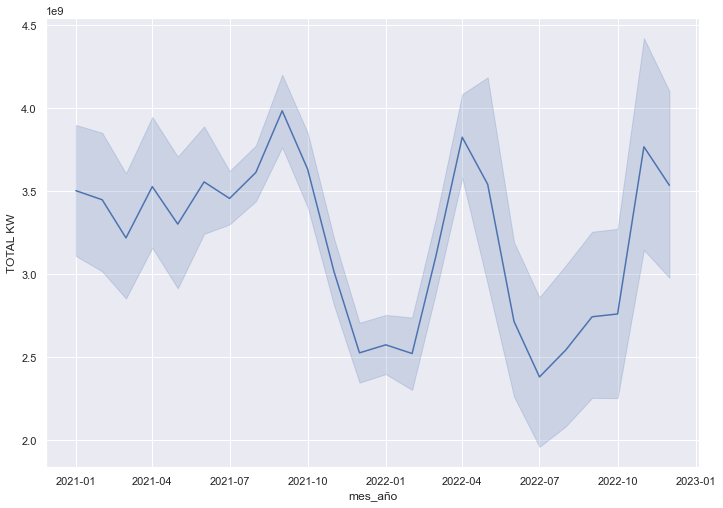

In [9]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(x="mes_año", y="TOTAL KW",
             data=serie)

In [10]:
serie.rename(columns = {'TOTAL KW':'total_kw'}, inplace = True)


In [20]:
check = serie[serie['mes_año']== '2022-01']

In [17]:
serie[serie['mes_año']== '2022-01']['total_kw'].min() , serie[serie['mes_año']== '2022-01']['total_kw'].max()

(11635522, 9953666306)

In [22]:
check.total_kw.value_counts()

5532001052    11
1597351677     1
1619132686     1
163094445      1
1598338137     1
              ..
2701784518     1
2776467476     1
2887487235     1
3069230719     1
2753500342     1
Name: total_kw, Length: 517, dtype: int64

<AxesSubplot:xlabel='total_kw'>

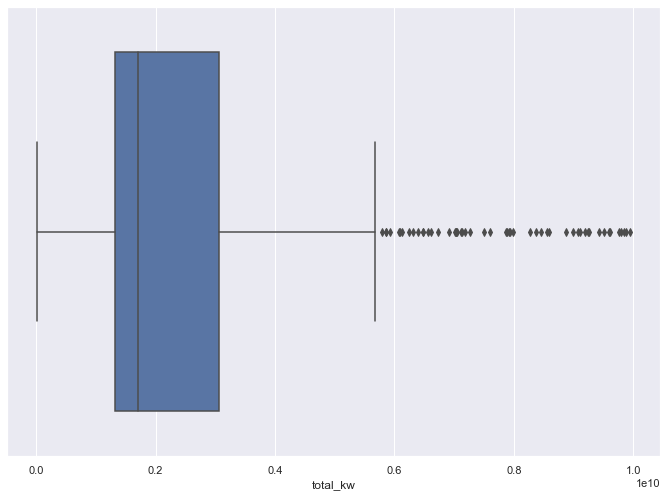

In [21]:
sns.boxplot(check.total_kw)

In [11]:
print(serie.total_kw.min(), serie.total_kw.max())

1151528 9990856094


<AxesSubplot:xlabel='total_kw'>

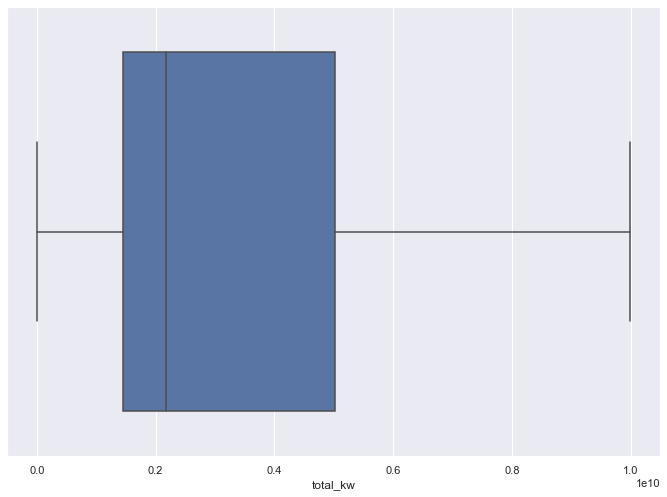

In [12]:
sns.boxplot(serie.total_kw)

<AxesSubplot:xlabel='mes_año', ylabel='Publico'>

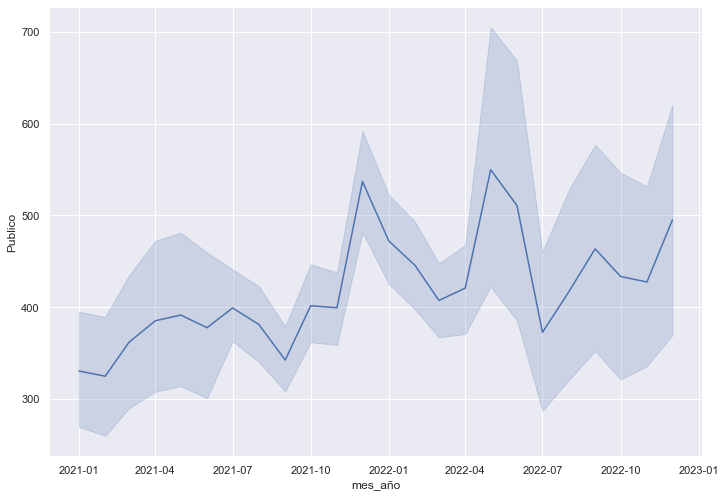

In [13]:
sns.lineplot(x="mes_año", y="Publico",
             data=serie)

<AxesSubplot:xlabel='mes_año', ylabel='TEMPERATURA'>

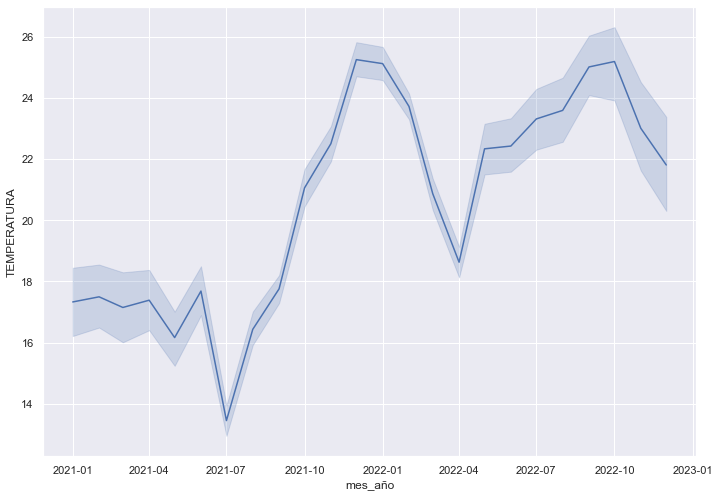

In [14]:
sns.lineplot(x="mes_año", y="TEMPERATURA",
             data=serie)

<AxesSubplot:xlabel='TEMPERATURA'>

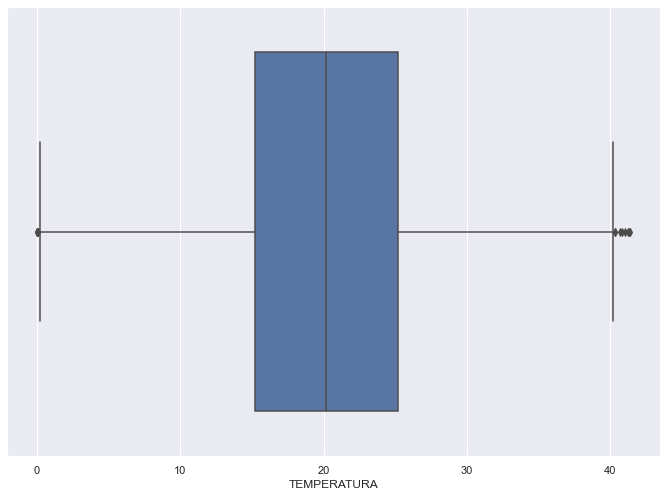

In [15]:
sns.boxplot(serie.TEMPERATURA)

In [23]:
def detect_trend (X_df):
    coefficients, residuals, _, _, _ = np.polyfit(range(len(X_df)),
                                                  X_df,
                                                  1,
                                                  full=True)

    mse = residuals[0]/(len(X_df))
    nrmse = np.sqrt(mse)/(X_df.max() - X_df.min())

    print('Slope ' + str(coefficients[0]))
    print('NRMSE: ' + str(nrmse))

    plt.xticks(rotation=90)
    plt.plot(X_df, 
             marker='.', 
             linestyle='-', 
             linewidth=0.5,
             color='blue',  
             label='Original')
    
    plt.plot([coefficients[0]*x + coefficients[1] for x in range(len(X_df))],
             marker='o', 
             markersize=8, 
             linestyle='-', 
             linewidth=0.5,
             color='orange',
             label='Regression line');
    plt.legend()
    plt.show()


Slope -92848.56765314768
NRMSE: 0.25288295551192735


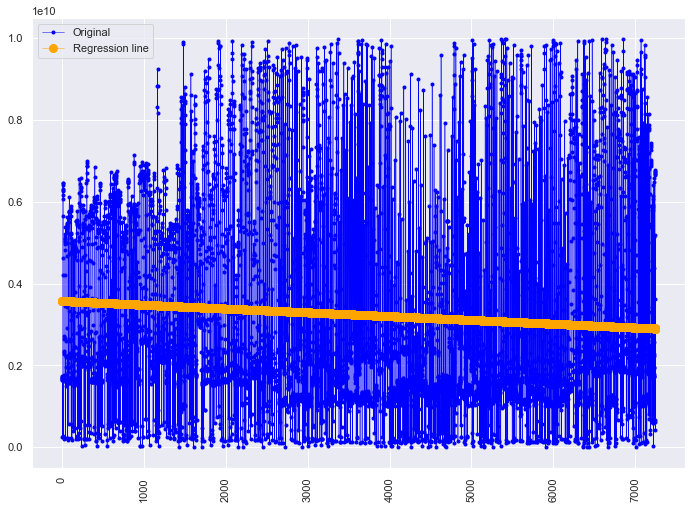

In [28]:
detect_trend(serie['total_kw'])


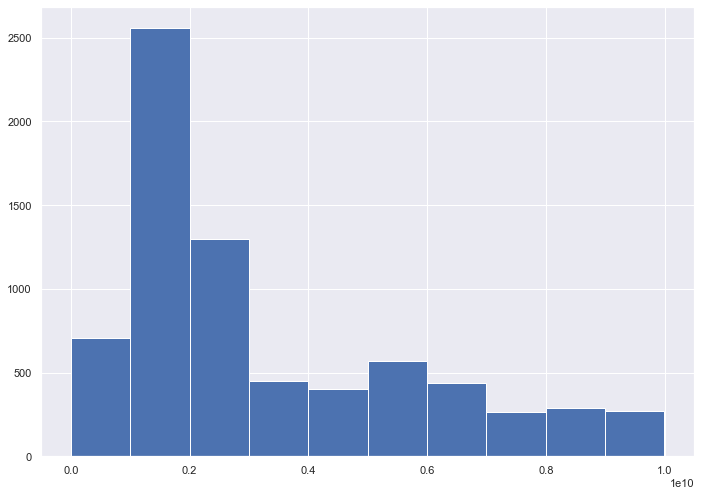

In [30]:
serie['total_kw'].hist();


In [37]:
serie.groupby("mes_año")[["total_kw"]].aggregate([min,
                                                        max,
                                                        sum,
                                                        'mean'])

total_kw                                         
                  min         max            sum          mean
mes_año                                                       
2021-01-01   16494716  9622617226   504453624580 3503150170.69
2021-02-01   57755264  9860271769   496579490857 3448468686.51
2021-03-01   27377037  9824081192   463469236671 3218536365.77
2021-04-01  119383511  9418043823   507955196248 3527466640.61
2021-05-01  155725698  9901120338   475456887823 3301783943.22
2021-06-01   18334798  9521964111   512056481690 3555947789.51
2021-07-01   19560729  9771120415  2073818974433 3456364957.39
2021-08-01    6478743  9911410637  2167857889011 3613096481.68
2021-09-01    5794719  9942287445  2294989844023 3984357368.10
2021-10-01   11159944  9967669525  2179079104178 3631798506.96
2021-11-01   18835488  9977660446  1733992399502 3015638955.66
2021-12-01   14878974  9853650894  1455241649469 2526461196.99
2022-01-01   11635522  9953666306  1356923078116 2574806599.84
2022-02-01   14406409  9977309132  1210729728905 2522353601.89
2022-03-01    1151528  9987377663  1715938773269 3108584734.18
2022-04-01   18061183  9982892685  2019683396547 3825157948.01
2022-05-01   13904072  9975659294   339996708357 3541632378.72
2022-06-01   11844203  9844097824   260713541506 2715766057.35
2022-07-01    2087398  9865866699   228613903781 2381394831.05
2022-08-01  120192953  9828052025   244195404877 2543702134.14
2022-09-01   10214144  9947700691   263394390919 2743691572.07
2022-10-01   20260313  9891043701   265020515502 2760630369.81
2022-11-01   27694047  9990856094   361684434025 3767546187.76
2022-12-01   73638413  9878484383   339417427880 3535598207.08